# Advanced validation and multi-step forecasting

In [74]:
import pandas as pd
import numpy as np
from datetime import datetime

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

# FEDOT framework
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

import warnings

To install FEDOT, run the following command

In [ ]:
pip install fedot==0.4.1

## Wave height forecasting 

In [3]:
df = pd.read_csv("data\\waves_mod.csv")
df.head(2)

,Hsig,RTpeak,PkDir,Hsig_distanced
0,0.03720,2.0523,45.0,0.022798
1,0.02223,2.0523,25.0,0.016980


## Train test split

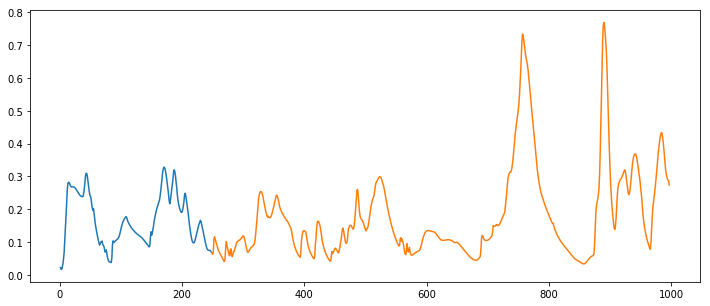

In [31]:
from sklearn.metrics import mean_absolute_error

test_size = 750
variable = df['Hsig']
train, test = variable[1: len(variable) - test_size], variable[len(variable) - test_size:]

plt.plot(train)
plt.plot(test)

For validation below will use "in-sample forecasting"

<img src="https://raw.githubusercontent.com/Dreamlone/ITMO_materials/master/images/in_sample.gif" width="650"/>

## FEDOT data preparation

In [32]:
from fedot.core.pipelines.ts_wrappers import in_sample_ts_forecast

def wrap_into_input(forecast_length, time_series):
    """ Convert data for FEDOT framework """
    time_series = np.array(time_series)
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))
    
    input_data = InputData(idx=np.arange(0, len(time_series)),
                           features=time_series, target=time_series,
                           task=task, data_type=DataTypesEnum.ts)
    
    return input_data

input_data_short_train = wrap_into_input(forecast_length=2, time_series=train)
input_data_short_test = wrap_into_input(forecast_length=2, time_series=variable)

input_data_long_train = wrap_into_input(forecast_length=10, time_series=train)
input_data_long_test = wrap_into_input(forecast_length=10, time_series=variable)

## Ridge model with lagged transformaton

<img src="https://raw.githubusercontent.com/Dreamlone/ITMO_materials/master/images/fig_2_autoregressive_models.png" width="700"/>

In [ ]:
warnings.filterwarnings('ignore')

def linear_pipeline():
    """ Pipeline lagged -> ridge """
    lagged_node = PrimaryNode('lagged') 
    ridge_node = SecondaryNode('ridge', nodes_from=[lagged_node])
    return Pipeline(ridge_node)

pipeline = linear_pipeline()
# Find best hyperparameters
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=input_data_short_train,
                                        iterations=100, timeout=5,
                                        cv_folds=3, validation_blocks=20)

pipeline.fit(input_data_short_train)

short_val_predict = in_sample_ts_forecast(pipeline=pipeline,
                                          input_data=input_data_short_test,
                                          horizon=test_size)

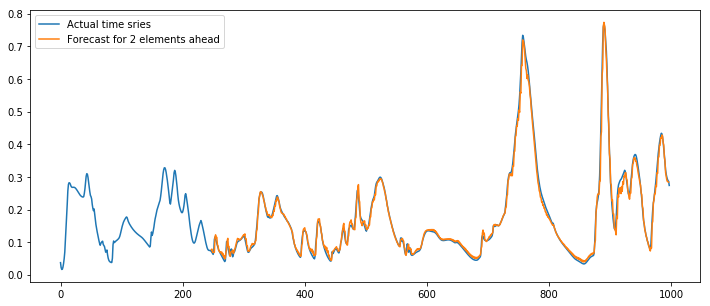

In [53]:
plt.plot(input_data_short_test.idx, input_data_short_test.target, label='Actual time sries')
plt.plot(np.arange(len(train), len(train) + len(short_val_predict)), short_val_predict, label='Forecast for 2 elements ahead')
plt.legend()
plt.show()

In [ ]:
pipeline = linear_pipeline()

# Find best hyperparameters 
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=input_data_long_train,
                                        iterations=100, timeout=5,
                                        cv_folds=3, validation_blocks=3)
pipeline.fit(input_data_long_train)

long_val_predict = in_sample_ts_forecast(pipeline=pipeline,
                                         input_data=input_data_long_test,
                                         horizon=test_size)

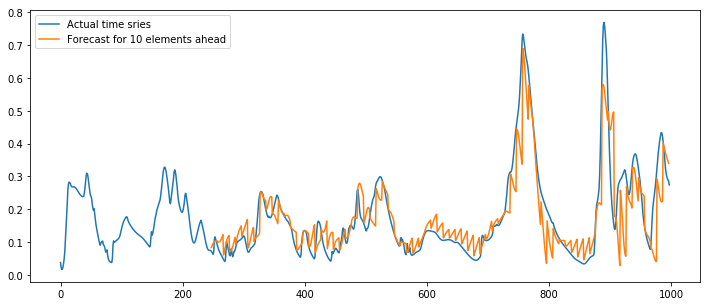

In [41]:
plt.plot(input_data_long_test.idx, input_data_long_test.target, label='Actual time sries')
plt.plot(np.arange(len(train), len(train) + len(long_val_predict)), long_val_predict, label='Forecast for 10 elements ahead')
plt.legend()
plt.show()

## Multi-step forecasting

Let's imagine that we need to use a model trained to predict 10 elements forward to predict 1000 elements. To do this, we will use the function. Thus, the model forecast (10 elements) become predictors for the next step 

In [69]:
from fedot.core.pipelines.ts_wrappers import out_of_sample_ts_forecast

lagged_node = PrimaryNode('lagged') 
lagged_node.custom_params = {'window_size': 80}
dtreg_node = SecondaryNode('dtreg', nodes_from=[lagged_node])
pipeline = Pipeline(dtreg_node)

time_series = wrap_into_input(forecast_length=10, time_series=variable)

# InputData for out-of-sample prediction 
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=10))
predict_input = InputData(idx=np.arange(len(variable)),
                          features=np.array(variable), target=np.array(variable),
                          task=task, data_type=DataTypesEnum.ts)

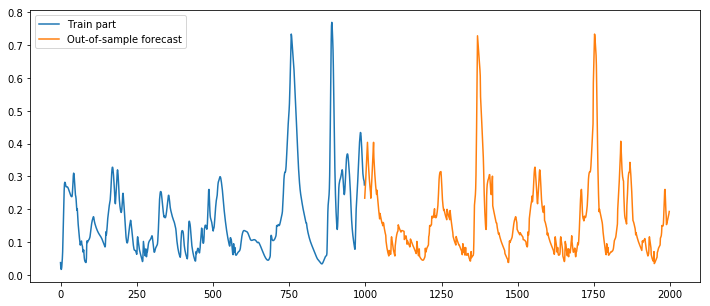

In [73]:
pipeline.fit(time_series)    
horizon = 1000
# Make forecast
ts_predicted = out_of_sample_ts_forecast(pipeline=pipeline,
                                         input_data=predict_input,
                                         horizon=horizon)

plt.plot(variable, label='Train part')
plt.plot(np.arange(len(variable), len(variable) + horizon), ts_predicted, label='Out-of-sample forecast')
plt.legend()
plt.show()